https://www.kaggle.com/competitions/oxford-102-flower-pytorch

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import cv2
import random
from skimage.io import imread
from sklearn.utils import class_weight
from collections import Counter
import time

In [2]:
# Tensorflow libraries and modules
import itertools
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import models, optimizers, regularizers

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# path dataset
path_train='flower_data/train/'
path_val='flower_data/valid/'
path_test='flower_data/test/'

In [5]:
# GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [6]:
num_cat=[]
for x in os.listdir(path_train):
    num_cat.append(x)
num_cat[0:5]

['27', '48', '69', '1', '10']

In [7]:
len(set(num_cat))

102

In [8]:
# Opening JSON file
f = open('flower_data/cat_to_name.json')
# json to dictionary
data_class = json.load(f)
# Closing file
f.close()

In [9]:
# dictionary classes
data_class['21']

'fire lily'

In [10]:
# make dataframe
train_folder_df=pd.DataFrame([data_class]).T
train_folder_df.columns=['class']

In [11]:
train_folder_df.head(3)

,class
21,fire lily
3,canterbury bells
45,bolero deep blue


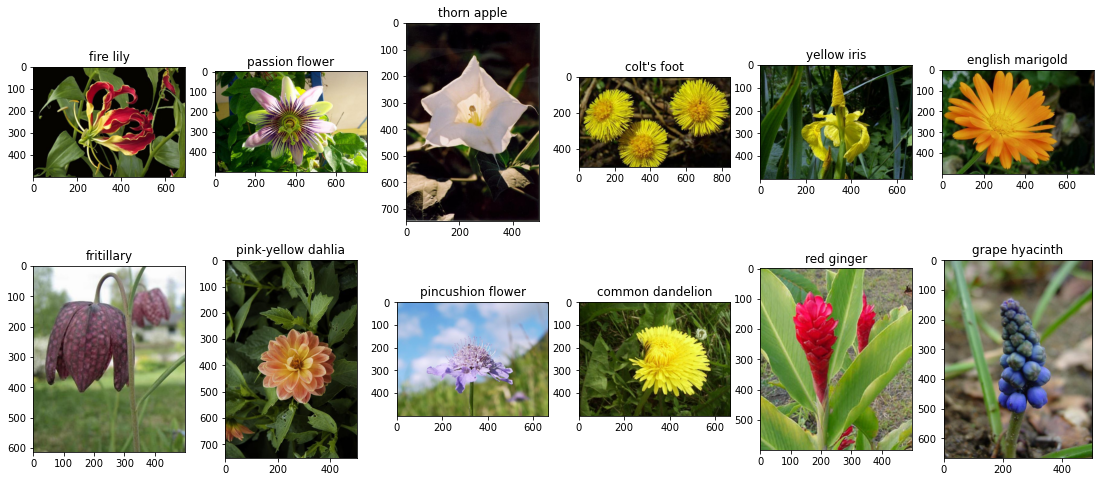

In [12]:
# plot some image examples
plt.figure(figsize = (19, 8))
i=1
for cl in range(12):
    im=train_folder_df.sample(n=1)
    ax=plt.subplot(2,6,i)
    path=path_train+im.index[0]+'/'
    #img = cv2.imread(path+random.choice(os.listdir(path)))
    img = imread(path+random.choice(os.listdir(path)))
    plt.imshow(img)
    plt.title(im['class'][0])
    i+=1
    

In [13]:
# counter (checking balance data classes)
counter={}
for i, row in train_folder_df.iterrows():
    count_={row[0]:len(os.listdir(path_train+i[0]))}
    counter.update(count_)
    
counter_df=pd.DataFrame([counter]).T.reset_index()  
counter_df.columns=['class','count']
counter_df['class_num']=train_folder_df.index
counter_df.head(3)

,class,count,class_num
0,fire lily,49,21
1,canterbury bells,36,3
2,bolero deep blue,44,45


In [14]:
# min max database flower class
counter_df.describe().T[['min', 'max']]

,min,max
count,27.0,70.0


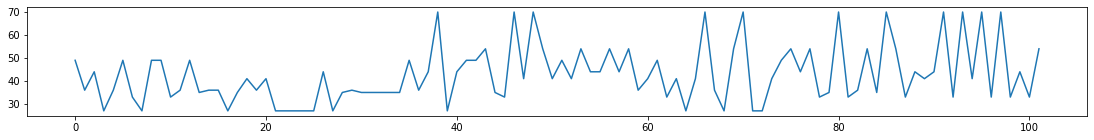

In [15]:
plt.figure(figsize = (19, 2))
plt.plot(counter_df.index, counter_df['count']);

## Convolutional Neural Network (CNN) TensorFlow

In [16]:
# target_size
target_size = (32,32)
# number of subprocesses data loading
num_workers = 4
# samples per batch to load
batch_size = 32
# input_shape
input_shape = (target_size[0],target_size[1], 3)

### Data Generator

In [17]:
# Datagen and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=None)

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Train / Validation - Data Generator
train_generator = train_datagen.flow_from_directory(path_train,
                                 target_size=target_size,
                                 batch_size=batch_size,
                                 class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(path_val,
                                 target_size=target_size,
                                 batch_size=batch_size,
                                 class_mode = 'categorical')

# Test 
test_generator = test_datagen.flow_from_directory(path_test,
                                 target_size=target_size,
                                 shuffle = False,
                                 batch_size=batch_size,
                                 class_mode = 'categorical')

Found 6552 images belonging to 102 classes.
Found 818 images belonging to 102 classes.
Found 819 images belonging to 1 classes.


In [19]:
all_values_class=[]
for i, row in counter_df.iterrows():
    for j in range(row[1]):
        all_values_class.append(row[2])
len(all_values_class)

4360

In [20]:
# class_weight - Unbalanced Data                       
#class_weights = dict(zip(np.unique(all_values_class), class_weight.compute_class_weight('balanced', np.unique(all_values_class),all_values_class)))
class_weights = None

In [21]:
# Define optimizer
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=6)
lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',patience=4) 

In [22]:
# plot output function
def plot_model_output(history, name='model'):
    
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    accuracy_values = history_dict['accuracy']
    val_accuracy_values = history_dict['val_accuracy']
    
    fig = plt.figure(figsize=(19,3))
    
    plt.subplot(1, 2, 1)
    plt.suptitle(name, fontsize=18)
    plt.title('loss')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,loss_values, '--',label='loss')
    plt.plot(epoch,val_loss_values, '--',label='val_loss')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('loss')
    
    plt.subplot(1, 2, 2)
    plt.suptitle(name, fontsize=18)
    plt.title('accuracy')
    epoch = range(1,len(loss_values)+1)
    plt.plot(epoch,accuracy_values, '--',label='accuracy')
    plt.plot(epoch,val_accuracy_values, '--',label='val_accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.show()

### Model

In [23]:
# Model VGG19
model_vgg19 = tf.keras.applications.VGG19(
    weights='imagenet',
    include_top = False,
    input_shape = input_shape)

for layer in model_vgg19.layers:
    layer.trainable=False
    
x = model_vgg19.output
x = Flatten()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dropout(0.2)(x)

# output layer
output_vgg19 = Dense(102, activation='softmax')(x)
# model
model_vgg19 = tf.keras.Model(inputs=model_vgg19.input, outputs=output_vgg19)
# name
model_vgg19._name = "model_vgg19"
# summary
#model_vgg19.summary()

2022-05-04 18:24:51.762915: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-04 18:24:51.762970: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: hellraiserPC
2022-05-04 18:24:51.762983: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: hellraiserPC
2022-05-04 18:24:51.763202: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 510.60.2
2022-05-04 18:24:51.763244: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 510.60.2
2022-05-04 18:24:51.763256: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 510.60.2
2022-05-04 18:24:51.764294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instruct

In [24]:
if os.path.exists('models/'):
    pass
else:
    os.makedirs('models/')

In [25]:
# run models fuction

filepath=os.getcwd()+'/models/'
def run_model(model):
    
    # save best model (callback)
    modelCheckpoint = ModelCheckpoint(filepath+'{}.h5'.format(model.name), save_best_only = True)
    
    # Compile the model
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    
    # Fit the model
    history = model.fit_generator(generator=train_generator,
                              epochs = epochs,
                              #steps_per_epoch=300,
                              callbacks=[early_stopping, lr, modelCheckpoint],
                              class_weight=class_weights,
                              validation_data = validation_generator)
    
    print(history.history.keys())
    
    return model, history

In [26]:
# Run model
epochs=10
max_accuracy=[]
custom_model, history_custom = run_model(model_vgg19)
max_accuracy.append(('{}.h5'.format(custom_model.name),np.max(history_custom.history['accuracy'])))

Epoch 1/10
205/205 [==============================] - 65s 312ms/step - loss: 4.3606 - accuracy: 0.0603 - val_loss: 3.9667 - val_accuracy: 0.1112 - lr: 0.0010
Epoch 2/10
205/205 [==============================] - 62s 304ms/step - loss: 3.8224 - accuracy: 0.1296 - val_loss: 3.4926 - val_accuracy: 0.2066 - lr: 0.0010
Epoch 3/10
205/205 [==============================] - 71s 348ms/step - loss: 3.5138 - accuracy: 0.1702 - val_loss: 3.1753 - val_accuracy: 0.2347 - lr: 0.0010
Epoch 4/10
205/205 [==============================] - 62s 300ms/step - loss: 3.2867 - accuracy: 0.2004 - val_loss: 3.0528 - val_accuracy: 0.2592 - lr: 0.0010
Epoch 5/10
205/205 [==============================] - 62s 301ms/step - loss: 3.1553 - accuracy: 0.2227 - val_loss: 2.9347 - val_accuracy: 0.2567 - lr: 0.0010
Epoch 6/10
205/205 [==============================] - 63s 306ms/step - loss: 3.0700 - accuracy: 0.2373 - val_loss: 2.9377 - val_accuracy: 0.2677 - lr: 0.0010
Epoch 7/10
205/205 [==============================] 

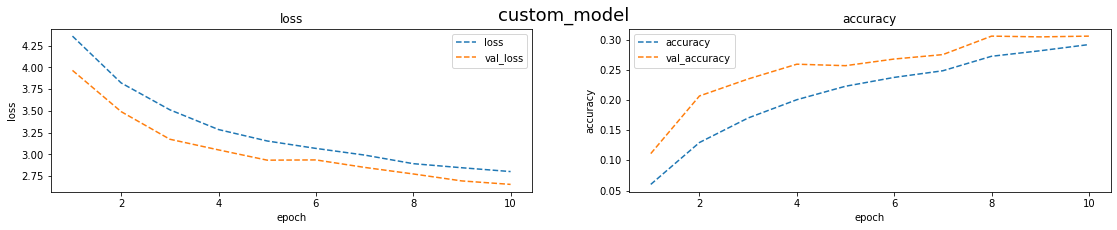

In [27]:
# plot model ouputs
plot_model_output(history_custom, 'custom_model')